In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LassoCV, LogisticRegression, LogisticRegressionCV 
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (confusion_matrix, roc_curve, auc, classification_report, 
ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, PredictionErrorDisplay)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.utils.discovery import all_displays
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import LearningCurveDisplay, learning_curve

from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

from scipy.stats import fisher_exact

from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.classifier.threshold import discrimination_threshold

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/Users/michael/Documents/MA Stats/STAT 8090/final dataset/full dataset.csv')

data.head()

,Symbol,Company_Name,Exchange,Orig_Range_Low,Orig_Range_High,Price,Shares,Offer_Amount,ipo_date,IPO_Year,...,plustwo_volume_pct,plusthree_change_pct,plusthree_volume_pct,plus90_change_pct,plus90_volume_pct,plus180_change_pct,plus180_volume_pct,d1_d180,d1_pop,d1_d180_pre_price
0,LXEO,Lexeo Therapeutics,Nasdaq,13.0,15.0,11.0,9090910,100000010,11/3/23,2023,...,0.013554,-0.005607,0.027481,-0.007088,0.008493,-0.010459,0.008693,1,0,1
1,MNR,Mach Resources,NYSE,19.0,21.0,19.0,10000000,190000000,10/25/23,2023,...,0.014016,-0.060652,0.014147,0.015936,0.004482,-0.021266,0.007779,1,0,1
2,BIRK,Birkenstock,NYSE,44.0,49.0,46.0,32258064,1483870944,10/11/23,2023,...,0.000001,0.037633,0.094204,-0.012492,0.017129,-0.002016,0.012965,1,0,0
3,KVYO,Klaviyo,NYSE,25.0,27.0,30.0,19200000,576000000,9/20/23,2023,...,0.093943,0.007383,0.130651,-0.048713,0.053359,0.022050,0.084599,0,1,1
4,CART,Maplebear,Nasdaq,26.0,28.0,30.0,22000000,660000000,9/19/23,2023,...,0.330195,-0.049430,0.202700,0.014551,0.063364,0.039052,0.193695,1,1,1


In [3]:
label_encoder = LabelEncoder()
data['Exchange'] = label_encoder.fit_transform(data['Exchange'])
data['Sector'] = label_encoder.fit_transform(data['Sector'])
data['Industry'] = label_encoder.fit_transform(data['Industry'])

In [4]:
data = data.drop(columns=['Symbol', 'Company_Name', 'ipo_date', 'Country_HQ', 'Pitchbook_Number',
                          'Orig_Range_Low', 'Orig_Range_High', 'Year_Founded', 'Raised_to_IPO',
                          'ipo_date_open','ipo_date_close','ipo_date_volume','plusone_open','plusone_close',
                          'plusone_volume','plustwo_open','plustwo_close','plustwo_volume','plusthree_open','plusthree_close',
                          'plusthree_volume','plus90_open','plus90_close','plus90_volume','plus180_open','plus180_close',
                          'plus180_volume','day_one_bump','ipo_date_change_pct','ipo_date_volume_pct','plusone_change_pct',
                          'plusone_volume_pct','plustwo_change_pct','plustwo_volume_pct','plusthree_change_pct',
                          'plusthree_volume_pct','plus90_change_pct','plus90_volume_pct','plus180_change_pct','plus180_volume_pct',
                          'd1_d180', 'd1_pop'])

In [5]:
data.head()

,Exchange,Price,Shares,Offer_Amount,IPO_Year,Years_to_IPO,Price_Low_Delta,Price_High_Delta,Sector,Industry,...,market_min5,market_min4,market_min3,market_min2,market_min1,market_min0,sent_negative,sent_neutral,sent_positive,d1_d180_pre_price
0,1,11.0,9090910,100000010,2023,5,-0.153846,-0.266667,5,12,...,13463.77810,14033.09100,13739.49652,13585.84000,13199.42727,13913.16048,0,0,0,1
1,0,19.0,10000000,190000000,2023,8,0.000000,-0.095238,3,63,...,15230.52727,15560.37143,16104.99500,15980.94783,15786.03000,15149.39545,0,0,0,1
2,0,46.0,32258064,1483870944,2023,249,0.045455,-0.061224,1,38,...,15230.52727,15560.37143,16104.99500,15980.94783,15786.03000,15149.39545,2,1,0,0
3,0,30.0,19200000,576000000,2023,11,0.200000,0.111111,8,79,...,15507.15789,15230.52727,15560.37143,16104.99500,15980.94783,15786.03000,1,0,0,1
4,1,30.0,22000000,660000000,2023,11,0.153846,0.071429,1,54,...,12073.46421,12446.53000,13463.77810,14033.09100,13739.49652,13585.84000,1,1,0,1


In [6]:
X = data.drop(columns=['d1_d180_pre_price'])
y = data['d1_d180_pre_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)

unique_values = set(X_train['Industry'])

# Check if at least one sample from each unique value is present in the training set
for value in unique_values:
    if value not in X_train['Industry'].unique():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)
        break

## Full Model

### RandomForest Classifier

In [7]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler', RandomUnderSampler()),
    ('classifier', RandomForestClassifier())
])

In [8]:
param_grid = {
    'classifier__n_estimators': [60, 80, 100, 120, 134], 
    'classifier__max_depth': [None, 5, 10, 20, 30, 40],  
    'classifier__min_samples_split': [2, 5, 10],  
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=10, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=60; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=60; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=60; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=60; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=60; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=60; total time=   0.0s
[CV] END classifier__max_depth=None

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sampler', RandomUnderSampler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [None, 5, 10, 20, 30, 40],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [60, 80, 100, 120, 134]},
             verbose=2)

In [9]:
ranks = pd.DataFrame(
    {
        'Model': grid_search.cv_results_['params'],
        'Mean Test Score': grid_search.cv_results_['mean_test_score'],
        'Std Test Score': grid_search.cv_results_['std_test_score'],
        'Rank': grid_search.cv_results_['rank_test_score']
    }
)

pd.concat([ranks.drop(['Model'], axis=1), ranks['Model'].apply(pd.Series)], axis=1).sort_values(by="Rank")

,Mean Test Score,Std Test Score,Rank,classifier__max_depth,classifier__min_samples_leaf,classifier__min_samples_split,classifier__n_estimators
122,0.678418,0.066099,1,10.0,4.0,2.0,100.0
151,0.676498,0.052015,2,20.0,2.0,2.0,80.0
247,0.673030,0.067984,3,40.0,2.0,5.0,100.0
267,0.671145,0.078438,4,40.0,4.0,10.0,100.0
153,0.671111,0.071335,5,20.0,2.0,2.0,120.0
...,...,...,...,...,...,...,...
70,0.609865,0.060583,266,5.0,2.0,10.0,60.0
93,0.608249,0.094849,267,10.0,1.0,2.0,120.0
181,0.606263,0.070871,268,30.0,1.0,2.0,80.0
176,0.602727,0.058104,269,20.0,4.0,10.0,80.0


In [10]:
best_estimator = grid_search.best_estimator_

print("Best Estimator:", best_estimator)

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()), ('sampler', RandomUnderSampler()),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=4))])


In [11]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [12]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
cm

Confusion Matrix:


array([[ 21,  17],
       [ 64, 130]])

In [13]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

odds_ratio, p_value = fisher_exact([[TP, FP], [FN, TN]])

log_odds_ratio = np.log(odds_ratio)

std_error_log_odds_ratio = np.sqrt(1/TP + 1/FP + 1/FN + 1/TN)

z_score = 1.96  # 95% confidence interval
lower_bound = log_odds_ratio - z_score * std_error_log_odds_ratio
upper_bound = log_odds_ratio + z_score * std_error_log_odds_ratio


ci_lower = np.exp(lower_bound)
ci_upper = np.exp(upper_bound)

print("95% Confidence Interval for Odds Ratio:", (ci_lower, ci_upper))
print("p-value for Odds Ratio:", p_value)

95% Confidence Interval for Odds Ratio: (1.238530198990995, 5.083477468056176)
p-value for Odds Ratio: 0.01574621063051928


In [14]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.55      0.34        38
           1       0.88      0.67      0.76       194

    accuracy                           0.65       232
   macro avg       0.57      0.61      0.55       232
weighted avg       0.78      0.65      0.69       232



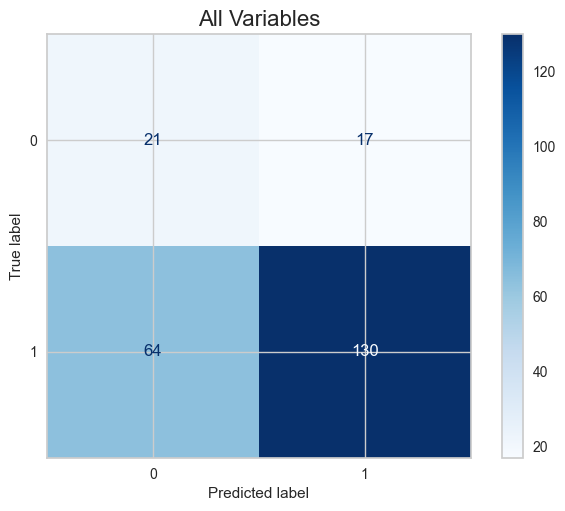

In [15]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('All Variables', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/cm_rf_tr_full.png', dpi=300, bbox_inches="tight")
plt.show()

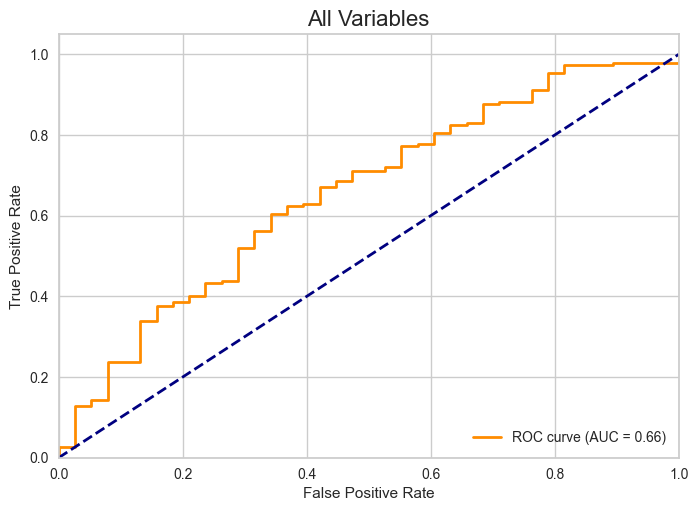

In [16]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All Variables', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/roc_rf_tr_full.png', dpi=300, bbox_inches="tight")
plt.show()

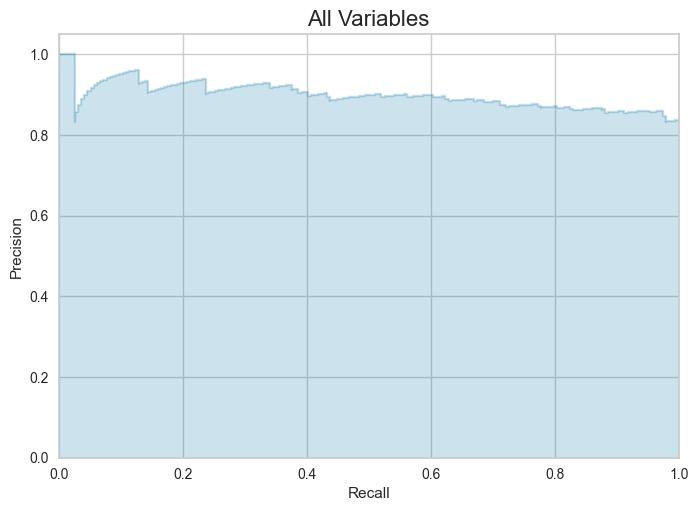

In [17]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('All Variables', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/prc_rf_tr_full.png', dpi=300, bbox_inches="tight")
plt.show()

In [18]:
# train_sizes, train_scores, test_scores = learning_curve(best_estimator, X, y)
# display = LearningCurveDisplay(train_sizes=train_sizes,
#                                train_scores=train_scores, test_scores=test_scores, score_name="accuracy")
# display.plot()
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Learning Curve')
# plt.show()

## Reduced Models

Lasso Regression is used to build the reduced model, with fewer predictor variables. This model will compared to the full model. 

### Lasso Regression and Random Forest

In [19]:
lasso_random_forest = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler', RandomUnderSampler()),
    ('feature_selection', SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'))), 
    ('classifier', RandomForestClassifier())
])

In [20]:
param_grid = {
    'classifier__n_estimators': [60, 80, 100, 120, 134], 
    'classifier__max_depth': [None, 5, 10, 20, 30, 40],  
    'classifier__min_samples_split': [2, 5, 10],  
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=lasso_random_forest, param_grid=param_grid, cv=10, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=60; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=60; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=60; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=60; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=60; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=60; total time=   0.0s
[CV] END classifier__max_depth=None

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sampler', RandomUnderSampler()),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                                                     solver='liblinear'))),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [None, 5, 10, 20, 30, 40],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [60, 80, 100, 120, 134]},
             verbose=2)

In [21]:
ranks = pd.DataFrame(
    {
        'Model': grid_search.cv_results_['params'],
        'Mean Test Score': grid_search.cv_results_['mean_test_score'],
        'Std Test Score': grid_search.cv_results_['std_test_score'],
        'Rank': grid_search.cv_results_['rank_test_score']
    }
)

pd.concat([ranks.drop(['Model'], axis=1), ranks['Model'].apply(pd.Series)], axis=1).sort_values(by="Rank")

,Mean Test Score,Std Test Score,Rank,classifier__max_depth,classifier__min_samples_leaf,classifier__min_samples_split,classifier__n_estimators
261,0.674882,0.070025,1,40.0,4.0,5.0,80.0
87,0.674747,0.058200,2,5.0,4.0,10.0,100.0
76,0.672862,0.061226,3,5.0,4.0,2.0,80.0
25,0.672862,0.070592,3,NaN,2.0,10.0,60.0
117,0.671010,0.071453,5,10.0,2.0,10.0,100.0
...,...,...,...,...,...,...,...
58,0.615556,0.079173,266,5.0,1.0,10.0,120.0
147,0.613906,0.091457,267,20.0,1.0,10.0,100.0
180,0.612054,0.079242,268,30.0,1.0,2.0,60.0
64,0.600943,0.078155,269,5.0,2.0,2.0,134.0


In [22]:
best_estimator = grid_search.best_estimator_

print("Best Estimator:", best_estimator)

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()), ('sampler', RandomUnderSampler()),
                ('feature_selection',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              solver='liblinear'))),
                ('classifier',
                 RandomForestClassifier(max_depth=40, min_samples_leaf=4,
                                        min_samples_split=5,
                                        n_estimators=80))])


In [23]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [24]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
cm

Confusion Matrix:


array([[ 22,  16],
       [ 76, 118]])

In [25]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

odds_ratio, p_value = fisher_exact([[TP, FP], [FN, TN]])

log_odds_ratio = np.log(odds_ratio)

std_error_log_odds_ratio = np.sqrt(1/TP + 1/FP + 1/FN + 1/TN)

z_score = 1.96  # 95% confidence interval
lower_bound = log_odds_ratio - z_score * std_error_log_odds_ratio
upper_bound = log_odds_ratio + z_score * std_error_log_odds_ratio


ci_lower = np.exp(lower_bound)
ci_upper = np.exp(upper_bound)

print("95% Confidence Interval for Odds Ratio:", (ci_lower, ci_upper))
print("p-value for Odds Ratio:", p_value)

95% Confidence Interval for Odds Ratio: (1.0542613296773073, 4.323086740365204)
p-value for Odds Ratio: 0.047215812546299016


In [26]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.58      0.32        38
           1       0.88      0.61      0.72       194

    accuracy                           0.60       232
   macro avg       0.55      0.59      0.52       232
weighted avg       0.77      0.60      0.65       232



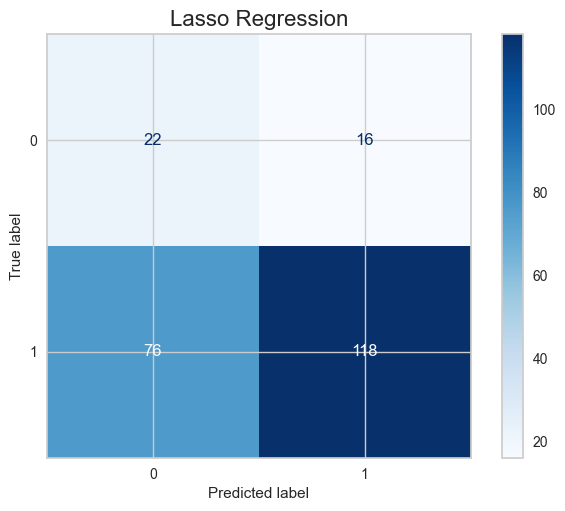

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Lasso Regression', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/cm_rf_tr_red1.png', dpi=300, bbox_inches="tight")
plt.show()

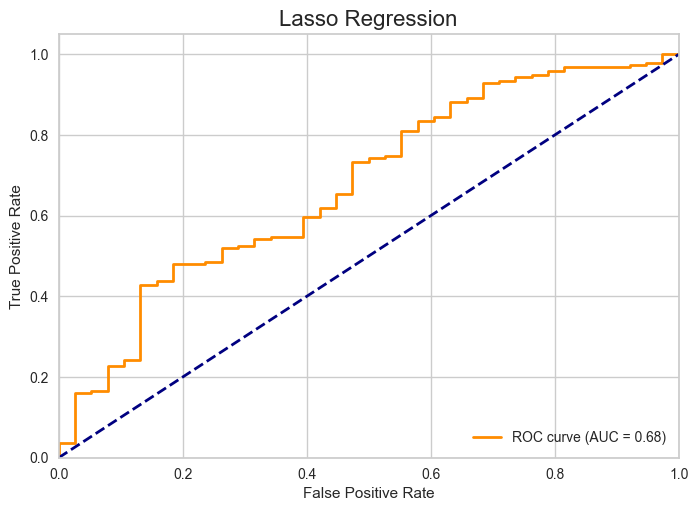

In [28]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Lasso Regression', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/roc_rf_tr_red1.png', dpi=300, bbox_inches="tight")
plt.show()

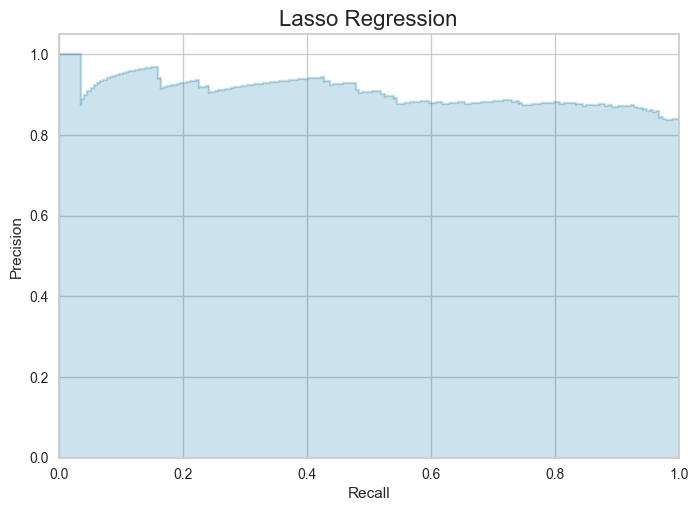

In [29]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Lasso Regression', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/prc_rf_tr_red1.png', dpi=300, bbox_inches="tight")
plt.show()

In [30]:
# train_sizes, train_scores, test_scores = learning_curve(best_estimator, X, y)
# display = LearningCurveDisplay(train_sizes=train_sizes,
#                                train_scores=train_scores, test_scores=test_scores, score_name="accuracy")
# display.plot()
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Learning Curve')
# plt.show()

## Feature Importance Models and Base Line Models

In [31]:
model = RandomForestClassifier()
model.fit(X, y)

feature_importance = pd.DataFrame(model.feature_importances_,
                                   index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [32]:
fi = feature_importance[feature_importance['importance'] >= 0.01]
fi = fi.index.tolist()

In [33]:
fi_data = X[fi]

In [34]:
fi_data.head()

,Price_High_Delta,Price_Low_Delta,Offer_Amount,raise_to_ipo_ratio,Shares,90_Trailing_IPO_plus95,Years_to_IPO,Price,Industry,completed_rounds_to_ipo,...,Corporation,market_min4,Venture_Capital_Round,sent_negative,market_min3,market_min6,number_of_bookrunners,Sector,market_min5,retail_sales_min2
0,-0.266667,-0.153846,100000010,0.337223,9090910,11,5,11.0,12,6,...,1,14033.09100,3,0,13739.49652,12446.53000,5,5,13463.77810,612633
1,-0.095238,0.000000,190000000,1.000000,10000000,12,8,19.0,63,4,...,0,15560.37143,0,0,16104.99500,15507.15789,5,3,15230.52727,608386
2,-0.061224,0.045455,1483870944,2.087695,32258064,14,249,46.0,38,6,...,0,15560.37143,0,2,16104.99500,15507.15789,11,1,15230.52727,608386
3,0.111111,0.200000,576000000,0.514286,19200000,16,11,30.0,79,8,...,0,15230.52727,5,1,15560.37143,15069.23478,8,8,15507.15789,603792
4,0.071429,0.153846,660000000,0.212219,22000000,15,11,30.0,54,17,...,0,12446.53000,9,1,13463.77810,11637.09217,5,1,12073.46421,603792


In [35]:
X_train, X_test, y_train, y_test = train_test_split(fi_data, y, test_size=0.3, random_state=8090)

unique_values = set(X_train['Industry'])

# Check if at least one sample from each unique value is present in the training set
for value in unique_values:
    if value not in X_train['Industry'].unique():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8090)
        break

In [36]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler', RandomUnderSampler()),
    ('classifier', RandomForestClassifier())
])

In [37]:
param_grid = {
    'classifier__n_estimators': [10, 20, 30, 32], 
    'classifier__max_depth': [None, 5, 10, 20, 30, 40],  
    'classifier__min_samples_split': [2, 5, 10],  
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=10, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=10; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=10; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=10; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=10; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=10; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=10; total time=   0.0s
[CV] END classifier__max_depth=None

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sampler', RandomUnderSampler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [None, 5, 10, 20, 30, 40],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [10, 20, 30, 32]},
             verbose=2)

In [38]:
ranks = pd.DataFrame(
    {
        'Model': grid_search.cv_results_['params'],
        'Mean Test Score': grid_search.cv_results_['mean_test_score'],
        'Std Test Score': grid_search.cv_results_['std_test_score'],
        'Rank': grid_search.cv_results_['rank_test_score']
    }
)

pd.concat([ranks.drop(['Model'], axis=1), ranks['Model'].apply(pd.Series)], axis=1).sort_values(by="Rank")

,Mean Test Score,Std Test Score,Rank,classifier__max_depth,classifier__min_samples_leaf,classifier__min_samples_split,classifier__n_estimators
186,0.680370,0.062658,1,40.0,1.0,5.0,30.0
13,0.680337,0.079738,2,NaN,2.0,2.0,20.0
154,0.680337,0.074399,3,30.0,1.0,10.0,30.0
51,0.678519,0.069995,4,5.0,2.0,2.0,32.0
104,0.678485,0.060230,5,10.0,4.0,10.0,10.0
...,...,...,...,...,...,...,...
0,0.598889,0.055557,212,NaN,1.0,2.0,10.0
108,0.595152,0.079806,213,20.0,1.0,2.0,10.0
72,0.593434,0.064539,214,10.0,1.0,2.0,10.0
181,0.567710,0.087277,215,40.0,1.0,2.0,20.0


In [39]:
best_estimator = grid_search.best_estimator_

print("Best Estimator:", best_estimator)

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()), ('sampler', RandomUnderSampler()),
                ('classifier',
                 RandomForestClassifier(max_depth=40, min_samples_split=5,
                                        n_estimators=30))])


In [40]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [41]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
cm

Confusion Matrix:


array([[ 22,  16],
       [ 69, 125]])

In [42]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

odds_ratio, p_value = fisher_exact([[TP, FP], [FN, TN]])

log_odds_ratio = np.log(odds_ratio)

std_error_log_odds_ratio = np.sqrt(1/TP + 1/FP + 1/FN + 1/TN)

z_score = 1.96  # 95% confidence interval
lower_bound = log_odds_ratio - z_score * std_error_log_odds_ratio
upper_bound = log_odds_ratio + z_score * std_error_log_odds_ratio


ci_lower = np.exp(lower_bound)
ci_upper = np.exp(upper_bound)

print("95% Confidence Interval for Odds Ratio:", (ci_lower, ci_upper))
print("p-value for Odds Ratio:", p_value)

95% Confidence Interval for Odds Ratio: (1.2272282669880756, 5.055939761715679)
p-value for Odds Ratio: 0.011502042167854916


In [43]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.58      0.34        38
           1       0.89      0.64      0.75       194

    accuracy                           0.63       232
   macro avg       0.56      0.61      0.54       232
weighted avg       0.78      0.63      0.68       232



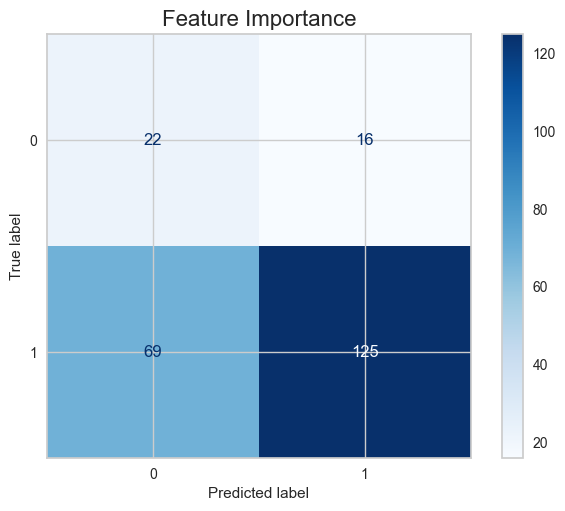

In [44]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Feature Importance', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/cm_rf_tr_fi.png', dpi=300, bbox_inches="tight")
plt.show()

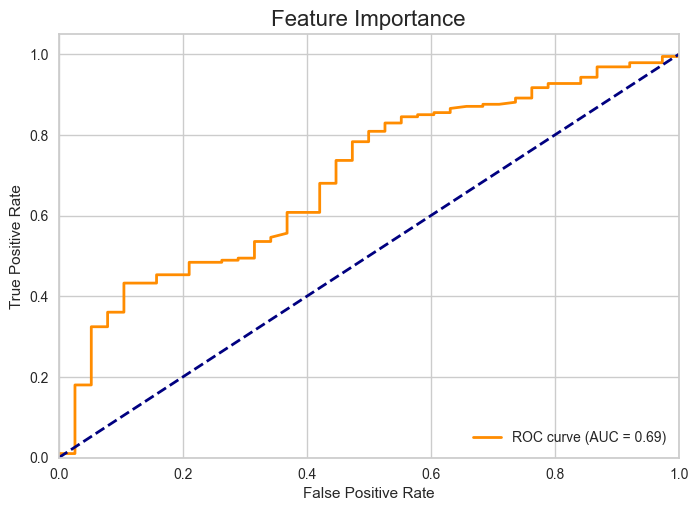

In [45]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Feature Importance', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/roc_rf_tr_fi.png', dpi=300, bbox_inches="tight")
plt.show()

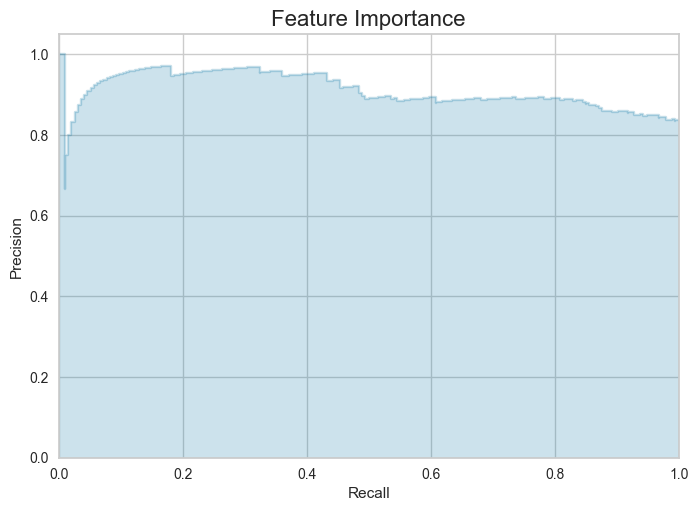

In [46]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, best_estimator.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Feature Importance', fontsize=16)
plt.savefig('/Users/michael/Documents/MA Stats/STAT 8090/prc_rf_tr_fi.png', dpi=300, bbox_inches="tight")
plt.show()

---
### End of Notebook